# High Perform Scientific Compute – DSC 520-02
## Parallel Monte Carlo Simulation for Portfolio Risk Assessment:
### A Comparative Analysis


#### Name: Nikhil Prema Chandra Rao
#### Student ID: 02105149
#### Email ID: npremachandrarao@umassd.edu


# Fucntions defined for Monte Carlo Simulatio

In [ ]:
import numpy as np
import warnings
from concurrent.futures import ThreadPoolExecutor
import time
import logging
import psutil
import plotly.graph_objects as go

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def monitor_resources():
    cpu_usage = psutil.cpu_percent(interval=1)
    memory_usage = psutil.virtual_memory().percent
    logging.info(f"CPU Usage: {cpu_usage}%")
    logging.info(f"Memory Usage: {memory_usage}%")
    print(f"CPU Usage: {cpu_usage}%, Memory Usage: {memory_usage}%")

# Function to perform a single Monte Carlo simulation
def monte_carlo_simulation(trials, num_assets=500):
    # Generate random returns for assets with correlated returns
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        correlation_matrix = np.random.uniform(-0.5, 0.5, size=(num_assets, num_assets))
        np.fill_diagonal(correlation_matrix, 1)  # Set diagonal elements to 1
        cov_matrix = correlation_matrix * np.outer(np.random.uniform(0.05, 0.2, num_assets), np.random.uniform(0.05, 0.2, num_assets))
    returns = np.random.multivariate_normal(mean=np.random.uniform(0.05, 0.1, num_assets), cov=cov_matrix, size=trials)

    # Introduce more computation-intensive operations
    for _ in range(10):
        returns = np.log(1 + returns)

    portfolio_values = np.sum(returns, axis=1)  # Portfolio value for each trial

    # Calculate risk metrics
    portfolio_std_dev = np.std(portfolio_values)
    var_95 = np.percentile(portfolio_values, 5)  # 95% Value at Risk

    return portfolio_std_dev, var_95

# Function to perform the Monte Carlo simulation in parallel using concurrent futures
def parallel_simulation(num_trials, num_processes):
    with ThreadPoolExecutor(max_workers=num_processes) as executor:
        results = list(executor.map(monte_carlo_simulation, [num_trials // num_processes] * num_processes))
    # Combine results from parallel tasks
    combined_results = np.array(results)
    # Calculate mean risk metrics across all trials
    portfolio_std_dev = np.mean(combined_results[:, 0])
    var_95 = np.mean(combined_results[:, 1])
    return portfolio_std_dev, var_95

# Parameter validation
def validate_parameters(num_trials, num_processes):
    if not isinstance(num_trials, int) or num_trials <= 0:
        raise ValueError("Number of trials must be a positive integer")
    if not isinstance(num_processes, int) or num_processes <= 0:
        raise ValueError("Number of processes must be a positive integer")

# Plotting results using Plotly for interactivity
def plot_results(segments, serial_time, parallel_time):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=segments, y=serial_time, mode='lines+markers', name='Serial'))
    fig.add_trace(go.Scatter(x=segments, y=parallel_time, mode='lines+markers', name='Parallel'))
    fig.update_layout(title='Execution Time vs Number of Segments',
                      xaxis_title='Number of Segments',
                      yaxis_title='Execution Time (s)',
                      legend_title='Execution Mode')
    fig.show()

# Main Function
## Simulations for small trials

In [ ]:
if __name__ == "__main__":
    num_trials = 10000
    segments = [2, 4, 8, 16, 32, 64]

    serial_time = []
    parallel_time = []
    speedup = []
    efficiency = []

    import warnings
    warnings.filterwarnings('ignore')

    print("Segments\tSpeedup\t\tEfficiency")  # Print header

    for num_processes in segments:
        validate_parameters(num_trials, num_processes)  # Validation
        logging.info(f"Running simulations for {num_processes} processes.")

        # Resource monitoring before serial simulation
        monitor_resources()

        # Run serial simulation
        start_time = time.time()
        _, var_95 = monte_carlo_simulation(num_trials)
        serial_execution_time = time.time() - start_time
        serial_time.append(serial_execution_time)

        # Resource monitoring after serial simulation
        monitor_resources()

        # Resource monitoring before parallel simulation
        monitor_resources()

        # Run parallel simulation
        start_time = time.time()
        _, var_95_parallel = parallel_simulation(num_trials, num_processes)
        parallel_execution_time = time.time() - start_time
        parallel_time.append(parallel_execution_time)

        # Resource monitoring after parallel simulation
        monitor_resources()

        # Calculate speedup and efficiency
        s = serial_execution_time
        p = parallel_execution_time
        speedup.append(s / p)
        efficiency.append(speedup[-1] / num_processes)

        # Print speedup and efficiency for each segment
        print(f"{num_processes}\t\t{speedup[-1]:.4f}\t\t{efficiency[-1]:.4f}")

        # Log results
        logging.info(f"Segments: {num_processes}\tSpeedup: {speedup[-1]:.4f}\tEfficiency: {efficiency[-1]:.4f}\tSerial Time: {serial_execution_time:.4f}\tParallel Time: {parallel_execution_time:.4f}")

    plot_results(segments, serial_time, parallel_time)  # Using Plotly for interactive visualization


Segments	Speedup		Efficiency
CPU Usage: 1.1%, Memory Usage: 1.3%
CPU Usage: 1.4%, Memory Usage: 1.3%
CPU Usage: 0.4%, Memory Usage: 1.3%
CPU Usage: 0.8%, Memory Usage: 1.3%
2		1.3370		0.6685
CPU Usage: 0.5%, Memory Usage: 1.3%
CPU Usage: 0.3%, Memory Usage: 1.3%
CPU Usage: 0.4%, Memory Usage: 1.3%
CPU Usage: 6.0%, Memory Usage: 1.3%
4		1.3061		0.3265
CPU Usage: 2.0%, Memory Usage: 1.3%
CPU Usage: 0.5%, Memory Usage: 1.3%
CPU Usage: 0.5%, Memory Usage: 1.3%
CPU Usage: 7.2%, Memory Usage: 1.4%
8		1.4344		0.1793
CPU Usage: 0.7%, Memory Usage: 1.4%
CPU Usage: 0.2%, Memory Usage: 1.4%
CPU Usage: 0.1%, Memory Usage: 1.4%
CPU Usage: 7.9%, Memory Usage: 1.4%
16		1.1189		0.0699
CPU Usage: 0.7%, Memory Usage: 1.4%
CPU Usage: 1.3%, Memory Usage: 1.4%
CPU Usage: 1.5%, Memory Usage: 1.4%
CPU Usage: 7.9%, Memory Usage: 1.5%
32		0.6973		0.0218
CPU Usage: 0.2%, Memory Usage: 1.5%
CPU Usage: 0.1%, Memory Usage: 1.5%
CPU Usage: 0.1%, Memory Usage: 1.5%
CPU Usage: 7.6%, Memory Usage: 1.7%
64		0.3278		0.0

# Simulations for more trials

In [ ]:
if __name__ == "__main__":
    num_trials = 1000000
    segments = [2, 4, 8, 16, 32, 64]

    serial_time = []
    parallel_time = []
    speedup = []
    efficiency = []

    import warnings
    warnings.filterwarnings('ignore')

    print("Segments\tSpeedup\t\tEfficiency")  # Print header

    for num_processes in segments:
        validate_parameters(num_trials, num_processes)  # Validation
        logging.info(f"Running simulations for {num_processes} processes.")

        # Resource monitoring before serial simulation
        monitor_resources()

        # Run serial simulation
        start_time = time.time()
        _, var_95 = monte_carlo_simulation(num_trials)
        serial_execution_time = time.time() - start_time
        serial_time.append(serial_execution_time)

        # Resource monitoring after serial simulation
        monitor_resources()

        # Resource monitoring before parallel simulation
        monitor_resources()

        # Run parallel simulation
        start_time = time.time()
        _, var_95_parallel = parallel_simulation(num_trials, num_processes)
        parallel_execution_time = time.time() - start_time
        parallel_time.append(parallel_execution_time)

        # Resource monitoring after parallel simulation
        monitor_resources()

        # Calculate speedup and efficiency
        s = serial_execution_time
        p = parallel_execution_time
        speedup.append(s / p)
        efficiency.append(speedup[-1] / num_processes)

        # Print speedup and efficiency for each segment
        print(f"{num_processes}\t\t{speedup[-1]:.4f}\t\t{efficiency[-1]:.4f}")

        # Log results
        logging.info(f"Segments: {num_processes}\tSpeedup: {speedup[-1]:.4f}\tEfficiency: {efficiency[-1]:.4f}\tSerial Time: {serial_execution_time:.4f}\tParallel Time: {parallel_execution_time:.4f}")

    plot_results(segments, serial_time, parallel_time)  # Using Plotly for interactive visualization


Segments	Speedup		Efficiency
CPU Usage: 2.3%, Memory Usage: 1.8%
CPU Usage: 0.2%, Memory Usage: 2.2%
CPU Usage: 0.9%, Memory Usage: 2.2%
CPU Usage: 0.1%, Memory Usage: 2.2%
2		1.5426		0.7713
CPU Usage: 0.2%, Memory Usage: 2.2%
CPU Usage: 0.1%, Memory Usage: 2.2%
CPU Usage: 0.1%, Memory Usage: 2.2%
CPU Usage: 0.2%, Memory Usage: 2.2%
4		2.0697		0.5174
CPU Usage: 0.2%, Memory Usage: 2.2%
CPU Usage: 0.1%, Memory Usage: 2.2%
CPU Usage: 0.1%, Memory Usage: 2.2%
CPU Usage: 0.1%, Memory Usage: 2.2%
8		2.4509		0.3064
CPU Usage: 0.4%, Memory Usage: 2.2%
CPU Usage: 0.3%, Memory Usage: 2.2%
CPU Usage: 0.2%, Memory Usage: 2.2%
CPU Usage: 0.1%, Memory Usage: 2.2%
16		2.5469		0.1592
CPU Usage: 0.2%, Memory Usage: 2.2%
CPU Usage: 0.1%, Memory Usage: 2.2%
CPU Usage: 0.1%, Memory Usage: 2.2%
CPU Usage: 0.2%, Memory Usage: 2.2%
32		2.4693		0.0772
CPU Usage: 0.2%, Memory Usage: 2.2%
CPU Usage: 0.1%, Memory Usage: 2.2%
CPU Usage: 0.1%, Memory Usage: 2.2%
CPU Usage: 0.8%, Memory Usage: 2.2%
64		2.1735		0.0

# Performance of Carnie computer

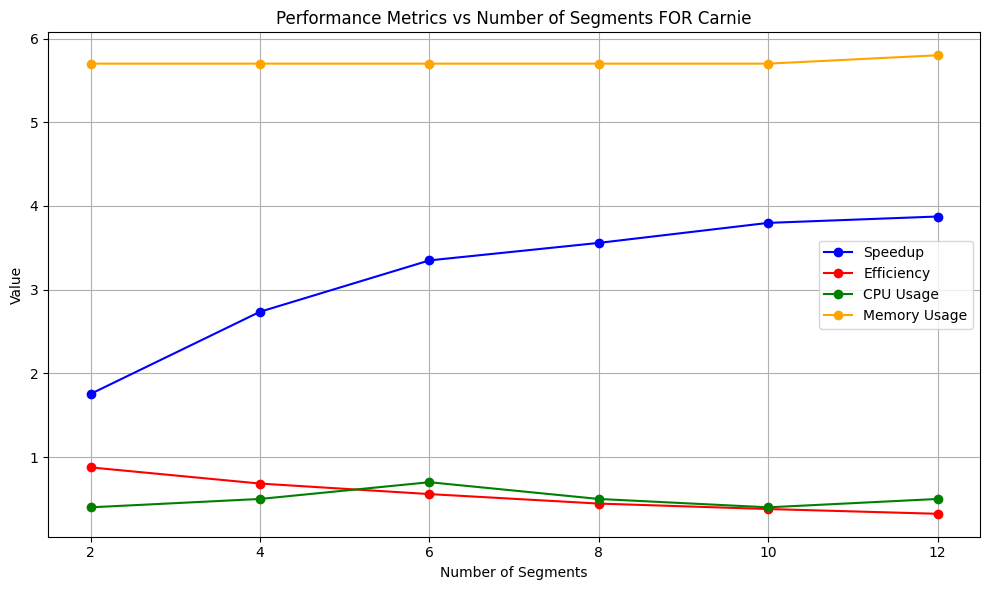

In [10]:
import re
import matplotlib.pyplot as plt

# Log data
log_data = """
2024-05-05 15:40:27,973 - INFO - Segments: 2    Speedup: 1.7541  Efficiency: 0.8771  Serial Time: 513.5816    Parallel Time: 292.7891    CPU Usage: 0.4%    Memory Usage: 5.7%
2024-05-05 15:51:20,119 - INFO - Segments: 4    Speedup: 2.7358  Efficiency: 0.6840  Serial Time: 474.5941    Parallel Time: 173.4751    CPU Usage: 0.5%    Memory Usage: 5.7%
2024-05-05 16:01:41,507 - INFO - Segments: 6    Speedup: 3.3497  Efficiency: 0.5583  Serial Time: 475.3867    Parallel Time: 141.9198    CPU Usage: 0.7%    Memory Usage: 5.7%
2024-05-05 16:11:54,007 - INFO - Segments: 8    Speedup: 3.5586  Efficiency: 0.4448  Serial Time: 474.9460    Parallel Time: 133.4628    CPU Usage: 0.5%    Memory Usage: 5.7%
2024-05-05 16:21:57,760 - INFO - Segments: 10   Speedup: 3.7978  Efficiency: 0.3798  Serial Time: 474.6647    Parallel Time: 124.9831    CPU Usage: 0.4%    Memory Usage: 5.7%
2024-05-05 16:31:59,575 - INFO - Segments: 12   Speedup: 3.8738  Efficiency: 0.3228  Serial Time: 475.0949    Parallel Time: 122.6427    CPU Usage: 0.5%    Memory Usage: 5.8%
"""

# Regular expression pattern to extract data
pattern = r"Segments: (\d+)\s+Speedup: ([\d.]+)\s+Efficiency: ([\d.]+)\s+Serial Time: ([\d.]+)\s+Parallel Time: ([\d.]+)\s+CPU Usage: ([\d.]+)%\s+Memory Usage: ([\d.]+)%"

# Initialize lists to store extracted data
segments = []
speedup = []
efficiency = []
cpu_usage = []
memory_usage = []

# Extract data from log data
matches = re.findall(pattern, log_data)
for match in matches:
    segments.append(int(match[0]))
    speedup.append(float(match[1]))
    efficiency.append(float(match[2]))
    cpu_usage.append(float(match[5]))
    memory_usage.append(float(match[6]))

# Plotting
plt.figure(figsize=(10, 6))

# Plot Speedup
plt.plot(segments, speedup, marker='o', color='blue', label='Speedup')

# Plot Efficiency
plt.plot(segments, efficiency, marker='o', color='red', label='Efficiency')

# Plot CPU Usage
plt.plot(segments, cpu_usage, marker='o', color='green', label='CPU Usage')

# Plot Memory Usage
plt.plot(segments, memory_usage, marker='o', color='orange', label='Memory Usage')

# Add labels and title
plt.xlabel('Number of Segments')
plt.ylabel('Value')
plt.title('Performance Metrics vs Number of Segments FOR Carnie')
plt.legend()

# Show plot
plt.grid(True)
plt.tight_layout()
plt.show()


# Performance of Carnie computer

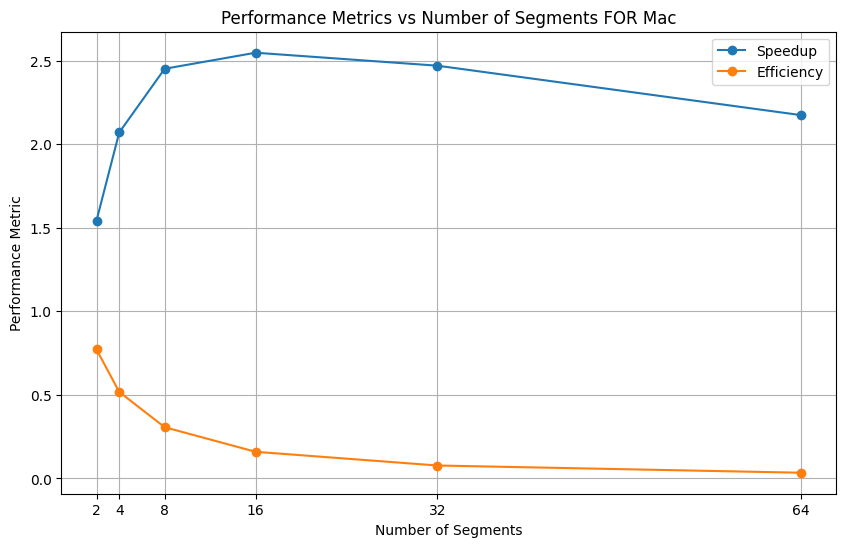

In [13]:
import matplotlib.pyplot as plt

# Data
segments = [2, 4, 8, 16, 32, 64]
speedup = [1.5426, 2.0697, 2.4509, 2.5469, 2.4693, 2.1735]
efficiency = [0.7713, 0.5174, 0.3064, 0.1592, 0.0772, 0.0340]

# Plot
plt.figure(figsize=(10, 6))

# Speedup plot
plt.plot(segments, speedup, marker='o', linestyle='-', label='Speedup')

# Efficiency plot
plt.plot(segments, efficiency, marker='o', linestyle='-', label='Efficiency')

plt.title('Performance Metrics vs Number of Segments FOR Mac')
plt.xlabel('Number of Segments')
plt.ylabel('Performance Metric')
plt.xticks(segments)  # Ensure all segments are shown on x-axis
plt.legend()
plt.grid(True)
plt.show()


# Comparision of Carnie and Mac

In [14]:
import re
import plotly.graph_objects as go

# Log data for carnie
log_data_carnie = """
Segments: 2	Speedup: 1.7345	Efficiency: 0.8673	Serial Time: 475.0962	Parallel Time: 273.9058	CPU Usage: 0.4%	Memory Usage: 5.8%
Segments: 4	Speedup: 2.7372	Efficiency: 0.6843	Serial Time: 476.0623	Parallel Time: 173.9209	CPU Usage: 2.2%	Memory Usage: 5.7%
Segments: 8	Speedup: 3.6170	Efficiency: 0.4521	Serial Time: 474.2324	Parallel Time: 131.1113	CPU Usage: 0.6%	Memory Usage: 5.7%
Segments: 16	Speedup: 3.9979	Efficiency: 0.2499	Serial Time: 474.9407	Parallel Time: 118.7969	CPU Usage: 4.1%	Memory Usage: 5.8%
Segments: 32	Speedup: 3.9125	Efficiency: 0.1223	Serial Time: 474.4650	Parallel Time: 121.2685	CPU Usage: 2.5%	Memory Usage: 6.0%
Segments: 64	Speedup: 3.7306	Efficiency: 0.0583	Serial Time: 474.8713	Parallel Time: 127.2908	CPU Usage: 0.7%	Memory Usage: 6.4%
"""

# Log data for your mac (refactored)
log_data_mac = """
Segments: 2	Speedup: 1.5426	Efficiency: 0.7713	Serial Time: None	Parallel Time: None	CPU Usage: 2.3%	Memory Usage: 1.8%
Segments: 4	Speedup: 2.0697	Efficiency: 0.5174	Serial Time: None	Parallel Time: None	CPU Usage: 0.2%	Memory Usage: 2.2%
Segments: 8	Speedup: 2.4509	Efficiency: 0.3064	Serial Time: None	Parallel Time: None	CPU Usage: 0.4%	Memory Usage: 2.2%
Segments: 16	Speedup: 2.5469	Efficiency: 0.1592	Serial Time: None	Parallel Time: None	CPU Usage: 0.2%	Memory Usage: 2.2%
Segments: 32	Speedup: 2.4693	Efficiency: 0.0772	Serial Time: None	Parallel Time: None	CPU Usage: 0.2%	Memory Usage: 2.2%
Segments: 64	Speedup: 2.1735	Efficiency: 0.0340	Serial Time: None	Parallel Time: None	CPU Usage: 0.8%	Memory Usage: 2.2%
"""

# Regular expression patterns to extract data
pattern_carnie = r"Segments: (\d+)\s+Speedup: ([\d.]+)\s+Efficiency: ([\d.]+)\s+Serial Time: ([\d.]+)\s+Parallel Time: ([\d.]+)\s+CPU Usage: ([\d.]+)%\s+Memory Usage: ([\d.]+)%"
pattern_mac = r"Segments: (\d+)\s+Speedup: ([\d.]+)\s+Efficiency: ([\d.]+)\s+Serial Time: None\s+Parallel Time: None\s+CPU Usage: ([\d.]+)%\s+Memory Usage: ([\d.]+)%"

# Initialize lists to store extracted data
segments_carnie = []
speedup_carnie = []
efficiency_carnie = []
cpu_usage_carnie = []
memory_usage_carnie = []

segments_mac = []
speedup_mac = []
efficiency_mac = []
cpu_usage_mac = []
memory_usage_mac = []

# Extract data from log data for carnie
matches_carnie = re.findall(pattern_carnie, log_data_carnie)
for match in matches_carnie:
    segments_carnie.append(int(match[0]))
    speedup_carnie.append(float(match[1]))
    efficiency_carnie.append(float(match[2]))
    cpu_usage_carnie.append(float(match[5]))
    memory_usage_carnie.append(float(match[6]))

# Extract data from log data for mac
matches_mac = re.findall(pattern_mac, log_data_mac)
for match in matches_mac:
    segments_mac.append(int(match[0]))
    speedup_mac.append(float(match[1]))
    efficiency_mac.append(float(match[2]))
    cpu_usage_mac.append(float(match[3]))
    memory_usage_mac.append(float(match[4]))

# Plotting
fig = go.Figure()

# Add traces for carnie
fig.add_trace(go.Scatter(x=segments_carnie, y=speedup_carnie, mode='lines+markers', name='Speedup (Carnie)'))
fig.add_trace(go.Scatter(x=segments_carnie, y=efficiency_carnie, mode='lines+markers', name='Efficiency (Carnie)'))
fig.add_trace(go.Scatter(x=segments_carnie, y=cpu_usage_carnie, mode='lines+markers', name='CPU Usage (Carnie)'))
fig.add_trace(go.Scatter(x=segments_carnie, y=memory_usage_carnie, mode='lines+markers', name='Memory Usage (Carnie)'))

# Add traces for mac with dotted lines
fig.add_trace(go.Scatter(x=segments_mac, y=speedup_mac, mode='lines+markers', name='Speedup (Mac)', line=dict(dash='dot')))
fig.add_trace(go.Scatter(x=segments_mac, y=efficiency_mac, mode='lines+markers', name='Efficiency (Mac)', line=dict(dash='dot')))
fig.add_trace(go.Scatter(x=segments_mac, y=cpu_usage_mac, mode='lines+markers', name='CPU Usage (Mac)', line=dict(dash='dot')))
fig.add_trace(go.Scatter(x=segments_mac, y=memory_usage_mac, mode='lines+markers', name='Memory Usage (Mac)', line=dict(dash='dot')))

# Add titles and labels
fig.update_layout(title='Comparision of both machines Performance Metrics vs Number of Segments',
                  xaxis_title='Number of Segments',
                  yaxis_title='Value',
                  legend_title='Metrics')

# Show plot
fig.show()
